In [1]:
epochs = 100

In [2]:
%matplotlib inline
import os, sys

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.
/home/admin/miniconda3/envs/da03/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/admin/miniconda3/envs/da03/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/admin/miniconda3/envs/da03/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/admin/miniconda3/env

In [3]:
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
#from gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras_ex.gkernel.sklearn import RBFClassifier

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()
X, y = digits.data, digits.target
X = X / 16
X.shape, X.min(), X.max()

((1797, 64), 0.0, 1.0)

In [5]:
y.shape

(1797,)

In [6]:
N = y.shape[0]
y2 = keras.utils.to_categorical(y, num_classes=10)
y2.shape
index = np.arange(N)
xtrain = X[index[index % 2 != 0],:]
ytrain = y2[index[index % 2 != 0]]
xtest = X[index[index % 2 == 0],:]
yans = y2[index[index % 2 == 0]]

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, Lasso
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import joblib

from lightgbm import LGBMClassifier

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
def f1_scorer(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(y, pred, average='macro')
    return s

## BENCHMARK LogisticRegression

In [10]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [11]:
param_name = "C"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [12]:
%%time

train_scores, test_scores = validation_curve(
    LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000),
    xtrain, np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.4s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   1.2s
[CV] C=10.0 ..........................................................
[CV] ........................................... C=10.0, total=   4.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   4.3s
[CV] C=1000.0 ........................................................
[CV] ......................................... C=1000.0, total=   4.0s
[CV] C

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   44.6s finished


In [13]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 1.81908749e-02, 1.82688944e-02],
       [1.00000000e-02, 1.80964287e-02, 1.80939848e-02],
       [1.00000000e-01, 8.83084412e-01, 8.17783004e-01],
       [1.00000000e+00, 9.85584329e-01, 9.31559398e-01],
       [1.00000000e+01, 1.00000000e+00, 9.41272087e-01],
       [1.00000000e+02, 1.00000000e+00, 9.44531466e-01],
       [1.00000000e+03, 1.00000000e+00, 9.42442747e-01]])

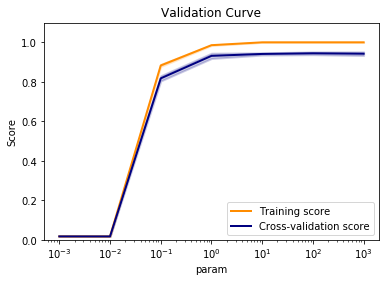

In [14]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [15]:
'''test data'''
est = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000, C=1000)
est.fit(xtrain, np.argmax(ytrain, axis=1))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
pred = est.predict(xtrain)

In [17]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.00        91

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 91  0  0  0  0]
 [ 0  0  0  0  0  0 90  0  0

In [18]:
pred_test = est.predict(xtest)

In [19]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9644145537214686
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       0.96      0.91      0.93        93
           2       0.98      1.00      0.99        86
           3       0.97      0.99      0.98        90
           4       1.00      0.97      0.98        93
           5       0.95      0.98      0.96        91
           6       1.00      0.98      0.99        91
           7       0.97      0.98      0.97        88
           8       0.88      0.92      0.90        88
           9       0.95      0.92      0.94        89

    accuracy                           0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 85  2  1  0  1  0  0  4  0]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 89  0  0  0  0  1  0]
 [ 0  0  0  0 90  0  0  1  0  2]
 [ 0  0  0  0  0 89  0  1  0  1]
 [ 0  0  0  0

## Bagging + Logit

In [20]:
from sklearn.ensemble import BaggingClassifier

In [21]:
clf = BaggingClassifier(
    LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000, C=1000),
    max_samples=0.5,
    verbose=2
)

In [22]:
clf.fit(xtrain, np.argmax(ytrain, axis=1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


BaggingClassifier(base_estimator=LogisticRegression(C=1000, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None,
                                                    max_iter=10000,
                                                    multi_class='multinomial',
                                                    n_jobs=None, penalty='l1',
                                                    random_state=None,
                                                    solver='saga', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=0.5, n_estimators=10, n_job

In [23]:
pred = clf.predict(xtrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [24]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9843736256502748
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       0.95      1.00      0.97        89
           2       0.99      0.99      0.99        91
           3       1.00      0.98      0.99        93
           4       1.00      0.98      0.99        88
           5       0.99      0.98      0.98        91
           6       0.99      0.99      0.99        90
           7       1.00      1.00      1.00        91
           8       0.98      0.95      0.96        86
           9       0.96      0.98      0.97        91

    accuracy                           0.98       898
   macro avg       0.98      0.98      0.98       898
weighted avg       0.98      0.98      0.98       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  1 90  0  0  0  0  0  0  0]
 [ 0  0  0 91  0  0  0  0  1  1]
 [ 0  0  0  0 86  0  0  0  0  2]
 [ 0  0  0  0  0 89  1  0  0  1]
 [ 0  1  0  0

In [25]:
pred_test = clf.predict(xtest)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [26]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9622725198201353
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       0.93      0.97      0.95        93
           2       0.98      0.99      0.98        86
           3       0.99      0.93      0.96        90
           4       1.00      0.97      0.98        93
           5       0.97      0.96      0.96        91
           6       1.00      0.98      0.99        91
           7       0.96      0.98      0.97        88
           8       0.88      0.92      0.90        88
           9       0.93      0.93      0.93        89

    accuracy                           0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 90  1  0  0  0  0  0  2  0]
 [ 0  1 85  0  0  0  0  0  0  0]
 [ 0  0  0 84  0  0  0  1  5  0]
 [ 0  0  0  0 90  0  0  1  0  2]
 [ 0  0  1  0  0 87  0  1  0  2]
 [ 0  0  0  0

## BENCHMARK LGBMClassifier

In [27]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [28]:
param_name = "reg_alpha"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [29]:
%%time

train_scores, test_scores = validation_curve(
    LGBMClassifier(
        min_child_samples=20,
        reg_alpha=0.1
    ),
    xtrain, np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] reg_alpha=0.001 .................................................
[CV] .................................. reg_alpha=0.001, total=   0.5s
[CV] reg_alpha=0.01 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ................................... reg_alpha=0.01, total=   0.5s
[CV] reg_alpha=0.1 ...................................................
[CV] .................................... reg_alpha=0.1, total=   0.4s
[CV] reg_alpha=1.0 ...................................................
[CV] .................................... reg_alpha=1.0, total=   0.3s
[CV] reg_alpha=10.0 ..................................................
[CV] ................................... reg_alpha=10.0, total=   0.2s
[CV] reg_alpha=100.0 .................................................
[CV] .................................. reg_alpha=100.0, total=   0.1s
[CV] reg_alpha=1000.0 ................................................
[CV] ................................. reg_alpha=1000.0, total=   0.1s
[CV] reg_alpha=0.001 .................................................
[CV] .................................. reg_alpha=0.001, total=   0.4s
[CV] reg_alpha=0.01 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    6.1s finished


In [30]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 1.00000000e+00, 9.28927200e-01],
       [1.00000000e-02, 1.00000000e+00, 9.30122641e-01],
       [1.00000000e-01, 1.00000000e+00, 9.22696488e-01],
       [1.00000000e+00, 1.00000000e+00, 9.11894179e-01],
       [1.00000000e+01, 9.52515614e-01, 8.66954158e-01],
       [1.00000000e+02, 1.86625194e-02, 1.89655172e-02],
       [1.00000000e+03, 1.86625194e-02, 1.89655172e-02]])

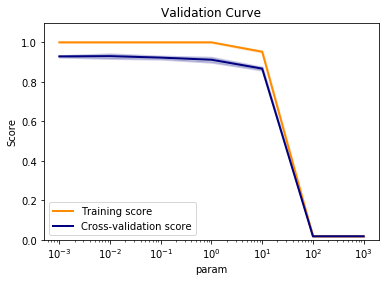

In [31]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [32]:
'''test data'''
est = LGBMClassifier(
        min_child_samples=20,
        reg_alpha=0.1
    )
est.fit(xtrain, np.argmax(ytrain, axis=1))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.1, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [33]:
pred = est.predict(xtrain)

In [34]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.00        91

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 91  0  0  0  0]
 [ 0  0  0  0  0  0 90  0  0

In [35]:
pred_test = est.predict(xtest)

In [36]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.962305803067745
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        90
           1       0.96      0.95      0.95        93
           2       0.98      0.99      0.98        86
           3       0.93      0.94      0.94        90
           4       0.99      0.94      0.96        93
           5       0.94      0.99      0.96        91
           6       1.00      0.96      0.98        91
           7       0.98      0.99      0.98        88
           8       0.92      0.93      0.93        88
           9       0.95      0.97      0.96        89

    accuracy                           0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899

[[88  0  0  0  0  2  0  0  0  0]
 [ 1 88  2  2  0  0  0  0  0  0]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 85  0  1  0  0  3  1]
 [ 0  2  0  0 87  0  0  0  1  3]
 [ 0  0  0  0  0 90  0  0  0  1]
 [ 0  0  0  0 

In [37]:
#clf = RBFClassifier(num_lm=3)
# clf = RBFClassifier(
#     num_lm=3,
#     lm=xtrain[:3]
# )
# clf = RBFClassifier(
#     num_lm=50,
#     lm=xtrain[:50],
#     make_model_gkernel=make_model_gkernel3
# )
# early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=0.000, restore_best_weights=True)
# clf = RBFClassifier(
#     num_lm=3,
#     lm=xtrain[np.random.choice(np.arange(xtrain.shape[0]), 3)],
# )
# clf = RBFClassifier(
#     num_lm=10,
#     lm=xtrain[:10],
#     callbacks=[early_stopping],
#     make_model_gkernel=make_model_gkernel3
# )
# clf = RBFClassifier(
#     num_lm=3,
#     lm=xtrain[:3],
#     make_model_gkernel=make_model_gkernel3,
#     activation='sigmoid',
#     loss='binary_crossentropy'
# )
clf = RBFClassifier(
    num_lm=10,
    lm=xtrain[np.random.choice(np.arange(xtrain.shape[0]), 10)],
    reg_l1=0.00,
    epochs_warmup=10,
    random_state=101
)
clf

In [38]:
%%time
hst = clf.fit(xtrain, ytrain, epochs=epochs, batch_size=32, verbose=0)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
CPU times: user 9.3 s, sys: 298 ms, total: 9.6 s
Wall time: 7.04 s


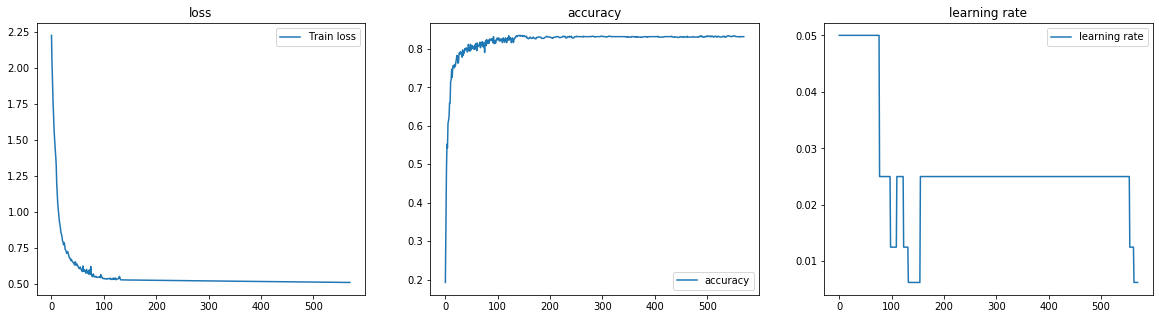

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [40]:
clf.n_classes_, clf.classes_

(10, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [41]:
clf.sk_params

{'num_lm': 10,
 'lm': array([[0.    , 0.    , 0.5   , 0.75  , 0.75  , 0.875 , 0.1875, 0.    ,
         0.    , 0.    , 0.6875, 0.6875, 0.625 , 1.    , 0.125 , 0.    ,
         0.    , 0.    , 0.    , 0.    , 0.5625, 0.8125, 0.    , 0.    ,
         0.    , 0.    , 0.    , 0.875 , 1.    , 0.8125, 0.    , 0.    ,
         0.    , 0.    , 0.    , 0.5   , 0.5   , 1.    , 0.25  , 0.    ,
         0.    , 0.    , 0.1875, 0.    , 0.    , 1.    , 0.25  , 0.    ,
         0.    , 0.0625, 1.    , 0.5625, 0.5625, 0.9375, 0.125 , 0.    ,
         0.    , 0.0625, 0.6875, 0.875 , 0.9375, 0.1875, 0.    , 0.    ],
        [0.    , 0.    , 0.5625, 1.    , 1.    , 1.    , 0.4375, 0.    ,
         0.    , 0.1875, 1.    , 0.6875, 0.25  , 0.25  , 0.0625, 0.    ,
         0.    , 0.375 , 1.    , 0.0625, 0.    , 0.    , 0.    , 0.    ,
         0.    , 0.5625, 1.    , 0.5625, 0.25  , 0.    , 0.    , 0.    ,
         0.    , 0.    , 0.375 , 0.625 , 1.    , 0.5   , 0.    , 0.    ,
         0.    , 0.    , 0.12

In [42]:
clf.__dict__

{'build_fn': <function keras_ex.gkernel.sklearn.make_model(make_model_gkernel=<function make_model_gkernel2 at 0x7f02465efd08>, make_model_out=<function make_model_out at 0x7f02465efe18>, reg_l1=0.0, reg_l2=0.0, nn=2, num_lm=2, lm=None, gamma=None, random_state=None, num_cls=2, activation='softmax', opt=0.02, lr=0.05, loss='categorical_crossentropy', session_clear=True, batch_size_middle=32, lm_select_from_x=None, tol=None, epochs_warmup=10)>,
 'sk_params': {'num_lm': 10,
  'lm': array([[0.    , 0.    , 0.5   , 0.75  , 0.75  , 0.875 , 0.1875, 0.    ,
          0.    , 0.    , 0.6875, 0.6875, 0.625 , 1.    , 0.125 , 0.    ,
          0.    , 0.    , 0.    , 0.    , 0.5625, 0.8125, 0.    , 0.    ,
          0.    , 0.    , 0.    , 0.875 , 1.    , 0.8125, 0.    , 0.    ,
          0.    , 0.    , 0.    , 0.5   , 0.5   , 1.    , 0.25  , 0.    ,
          0.    , 0.    , 0.1875, 0.    , 0.    , 1.    , 0.25  , 0.    ,
          0.    , 0.0625, 1.    , 0.5625, 0.5625, 0.9375, 0.125 , 0.    ,

In [43]:
clf.current_gamma()

0.13608652

In [44]:
clf.predict(xtrain)[:10]

array([1, 3, 3, 7, 9, 1, 3, 5, 8, 3])

In [45]:
clf.predict_proba(xtest)[:5]

array([[9.9985325e-01, 7.1755091e-13, 2.0237605e-05, 2.1879270e-09,
        1.6838033e-08, 2.5187151e-06, 1.1734737e-04, 4.4573159e-08,
        4.5120905e-06, 2.0315215e-06],
       [3.0345641e-04, 5.8736509e-01, 7.4624762e-02, 2.2333881e-03,
        8.8630177e-02, 5.4342177e-05, 6.7252717e-03, 1.9100644e-01,
        3.9095934e-02, 9.9611143e-03],
       [2.0477553e-03, 1.1048194e-01, 1.2055491e-03, 2.0763508e-04,
        7.4035430e-01, 8.4188429e-04, 4.1285060e-02, 7.9583056e-02,
        7.3847608e-03, 1.6608091e-02],
       [5.0799530e-03, 1.7700896e-02, 7.8123426e-03, 5.2389794e-04,
        1.6399455e-01, 4.7094375e-02, 6.4202762e-01, 1.6735733e-02,
        9.4689272e-02, 4.3413159e-03],
       [4.2701137e-04, 5.7811040e-04, 2.7426213e-02, 1.5610322e-01,
        3.5753801e-05, 2.1512192e-02, 6.3500758e-03, 2.2873130e-01,
        4.3422237e-01, 1.2461385e-01]], dtype=float32)

In [46]:
clf.score(xtrain, ytrain)

898/898 [==============================] - 0s 177us/step


0.8318485523385301

In [47]:
clf.score(xtest, yans)

899/899 [==============================] - 0s 22us/step


0.8242491658060118

In [48]:
print('F1_SCORE :', f1_score(np.argmax(ytrain,axis=1), clf.predict(xtrain), average='macro'))
print(classification_report(np.argmax(ytrain,axis=1), clf.predict(xtrain)))
print(confusion_matrix(np.argmax(ytrain,axis=1), clf.predict(xtrain)))

F1_SCORE : 0.8313147754973522
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        88
           1       0.84      0.82      0.83        89
           2       0.92      0.89      0.91        91
           3       0.82      0.80      0.81        93
           4       0.85      0.89      0.87        88
           5       0.91      0.88      0.89        91
           6       0.82      0.84      0.83        90
           7       0.78      0.81      0.80        91
           8       0.62      0.60      0.61        86
           9       0.77      0.79      0.78        91

    accuracy                           0.83       898
   macro avg       0.83      0.83      0.83       898
weighted avg       0.83      0.83      0.83       898

[[87  0  0  0  1  0  0  0  0  0]
 [ 0 73  3  0  3  0  2  2  0  6]
 [ 0  3 81  0  0  0  0  3  4  0]
 [ 0  0  1 74  0  2  0  2  6  8]
 [ 1  4  1  0 78  0  4  0  0  0]
 [ 0  0  0  1  0 80  5  0  2  3]
 [ 0  3  0  0

In [49]:
print('F1_SCORE :', f1_score(np.argmax(yans,axis=1), clf.predict(xtest), average='macro'))
print(classification_report(np.argmax(yans,axis=1), clf.predict(xtest)))
print(confusion_matrix(np.argmax(yans,axis=1), clf.predict(xtest)))

F1_SCORE : 0.8247600189912321
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        90
           1       0.78      0.77      0.78        93
           2       0.85      0.93      0.89        86
           3       0.90      0.78      0.83        90
           4       0.88      0.82      0.85        93
           5       0.86      0.77      0.81        91
           6       0.73      0.84      0.78        91
           7       0.85      0.85      0.85        88
           8       0.69      0.69      0.69        88
           9       0.73      0.81      0.77        89

    accuracy                           0.82       899
   macro avg       0.83      0.82      0.82       899
weighted avg       0.83      0.82      0.82       899

[[89  0  0  0  0  0  1  0  0  0]
 [ 0 72  7  0  5  1  3  0  0  5]
 [ 0  2 80  0  0  0  0  1  2  1]
 [ 0  0  0 70  0  0  0  2 10  8]
 [ 0  9  0  0 76  0  6  2  0  0]
 [ 0  1  0  0  0 70 11  0  3  6]
 [ 0  2  0  0

In [50]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [51]:
param_name = "num_lm"
param_range = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300]
param_range

[2, 5, 10, 20, 50, 100, 150, 200, 250, 300]

In [52]:
%%time

def f1_scorer_2(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(np.argmax(y, axis=1), pred, average='macro')
    return s

train_scores, test_scores = validation_curve(
    RBFClassifier(
        num_lm=2,
        lm_select_from_x=True,
        random_state=None,
        gamma='scale',
        epochs=epochs, batch_size=100, verbose=0
    ),
    xtrain, ytrain,
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer_2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] num_lm=2 ........................................................
[CV] ......................................... num_lm=2, total=   4.4s
[CV] num_lm=5 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] ......................................... num_lm=5, total=   6.5s
[CV] num_lm=10 .......................................................
[CV] ........................................ num_lm=10, total=   7.4s
[CV] num_lm=20 .......................................................
[CV] ........................................ num_lm=20, total=   7.2s
[CV] num_lm=50 .......................................................
[CV] ........................................ num_lm=50, total=   5.4s
[CV] num_lm=100 ......................................................
[CV] ....................................... num_lm=100, total=   5.3s
[CV] num_lm=150 ......................................................
[CV] ....................................... num_lm=150, total=   4.5s
[CV] num_lm=200 ......................................................
[CV] ....................................... num_lm=200, total=   6.1s
[CV] num_lm=250 ......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.1min finished


In [53]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[  2.        ,   0.38157391,   0.40350095],
       [  5.        ,   0.66786985,   0.65215661],
       [ 10.        ,   0.88641193,   0.8612675 ],
       [ 20.        ,   0.94447122,   0.91386936],
       [ 50.        ,   0.98909898,   0.94093839],
       [100.        ,   0.99883975,   0.94910889],
       [150.        ,   0.99885458,   0.95876779],
       [200.        ,   1.        ,   0.95575746],
       [250.        ,   0.99943499,   0.95358355],
       [300.        ,   0.99943499,   0.95781439]])

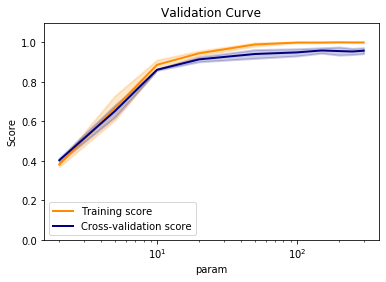

In [54]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [55]:
%%time

'''test data'''
est = RBFClassifier(
    num_lm=150,
    lm_select_from_x=True,
    random_state=None,
    gamma='scale',
    lr=0.05,
    epochs=epochs, batch_size=100, verbose=0
)
hst = est.fit(xtrain, ytrain)

CPU times: user 7.63 s, sys: 184 ms, total: 7.82 s
Wall time: 6.24 s


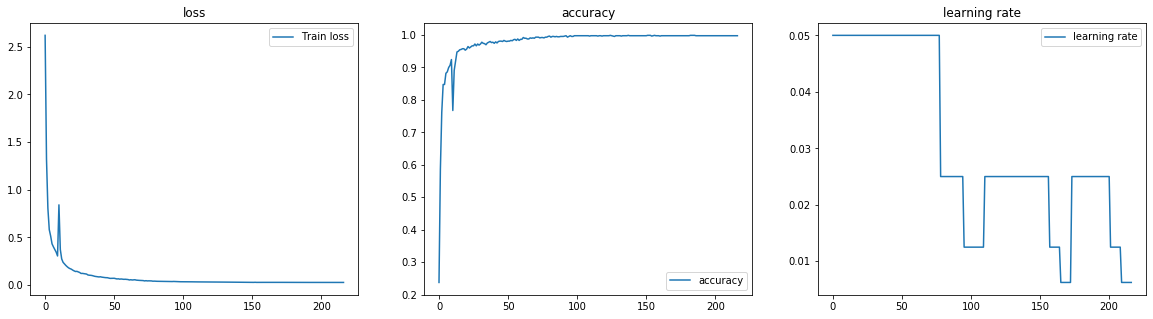

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [57]:
pred = est.predict(xtrain)

In [58]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9977705780311726
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        88
           5       1.00      0.99      0.99        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        91
           8       0.99      1.00      0.99        86
           9       0.99      0.99      0.99        91

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 90  0  0  0  1]
 [ 0  0  0  0

In [59]:
pred_test = est.predict(xtest)

In [60]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9712020658557632
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      0.96      0.98        93
           2       0.99      1.00      0.99        86
           3       0.95      0.98      0.96        90
           4       0.99      0.97      0.98        93
           5       0.94      0.96      0.95        91
           6       1.00      0.95      0.97        91
           7       0.97      0.98      0.97        88
           8       0.96      0.99      0.97        88
           9       0.93      0.94      0.94        89

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 89  1  0  0  1  0  0  1  1]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 88  0  0  0  1  1  0]
 [ 0  0  0  0 90  0  0  1  0  2]
 [ 0  0  0  1  1 87  0  0  0  2]
 [ 0  0  0  0

In [61]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, Lasso
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import joblib

In [62]:
%%time

ins_splitter = StratifiedShuffleSplit(n_splits=50, test_size=0.5, random_state=0)
var_idx_all = np.arange(xtrain.shape[1])
threshold = 0.95
#threshold = 0.30
importances = np.zeros((xtrain.shape[1],))
predictions = pd.DataFrame()
#preds_all = pd.DataFrame()
pred_all_list = []
pred_train_all_list = []
counter = 0
np.random.seed(10001)

print("counter  | val_f1    |  val_r2    ")
print("---------------------------------------------")


for train_index, val_index in ins_splitter.split(xtrain, ytrain):
    x_train_tr, x_train_val = xtrain[train_index], xtrain[val_index]
    y_train_tr, y_train_val = ytrain[train_index], ytrain[val_index]
    
    
    #estimator = LGBMRegressor(min_child_samples=50, reg_alpha=100)
    estimator = RBFClassifier(
        num_lm=250,
        lm_select_from_x=True,
        random_state=None,
        gamma='scale',
        epochs=epochs, batch_size=100, verbose=0
    )
    estimator.fit(x_train_tr, y_train_tr)
    
    # score our fitted model on validation data
    val_y_pred = estimator.predict(x_train_val)
    val_mse = mean_squared_error(np.argmax(y_train_val,axis=1), val_y_pred)
    val_mae = mean_absolute_error(np.argmax(y_train_val,axis=1), val_y_pred)
    val_kappa = 0.0
    val_f1 = f1_score(np.argmax(y_train_val,axis=1), val_y_pred, average='macro')
    val_cos = cosine_similarity(np.argmax(y_train_val,axis=1).reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_dst = euclidean_distances(np.argmax(y_train_val,axis=1).reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_r2  = r2_score(np.argmax(y_train_val,axis=1), val_y_pred)
    gamma = estimator.current_gamma()
    
    if val_f1 > threshold:
        message = '<-- OK'
        pred_train_all = estimator.predict_proba(xtrain)
        pred_train_all_list.append(pred_train_all)
        pred_all = estimator.predict_proba(xtest)
        pred_all_list.append(pred_all)
        #preds_all = pd.concat([preds_all, pd.DataFrame(pred_all)], axis=1)
        #prediction = grid_search.best_estimator_.predict(x_test0)
        #predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
        #importances += estimator.feature_importances_
        #filename = 'model-{}.sav'.format(counter)
        #joblib.dump(estimator, filename)
    else:
        message = '<-- skipping'

    print("{0:5}    |  {3:.4f}   |  {4:.4f}   {5:5e} {7}  ".format(
        counter,
        val_mse,
        val_mae,
        val_f1,
        val_r2,
        gamma,
        0,
        message))
    
    counter += 1

counter  | val_f1    |  val_r2    
---------------------------------------------
    0    |  0.9488   |  0.8451   1.993003e-01 <-- skipping  
    1    |  0.9711   |  0.9346   2.072529e-01 <-- OK  
    2    |  0.9555   |  0.8501   2.081666e-01 <-- OK  
    3    |  0.9688   |  0.9224   1.977860e-01 <-- OK  
    4    |  0.9575   |  0.8734   1.974298e-01 <-- OK  
    5    |  0.9461   |  0.8716   1.856885e-01 <-- skipping  
    6    |  0.9664   |  0.9021   2.042451e-01 <-- OK  
    7    |  0.9590   |  0.8709   1.914193e-01 <-- OK  
    8    |  0.9647   |  0.9163   2.142216e-01 <-- OK  
    9    |  0.9504   |  0.8847   1.940121e-01 <-- OK  
   10    |  0.9710   |  0.9404   1.949324e-01 <-- OK  
   11    |  0.9513   |  0.8053   2.025113e-01 <-- OK  
   12    |  0.9619   |  0.9148   1.948561e-01 <-- OK  
   13    |  0.9382   |  0.7693   1.851822e-01 <-- skipping  
   14    |  0.9508   |  0.8530   2.077445e-01 <-- OK  
   15    |  0.9528   |  0.8948   1.935377e-01 <-- OK  
   16    |  0.9535   

In [63]:
for ee in pred_train_all_list:
    print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), np.argmax(ee, axis=1), average='macro'))

F1_SCORE : 0.9855071139809519
F1_SCORE : 0.9777808443043989
F1_SCORE : 0.9843728241495414
F1_SCORE : 0.9788233007977478
F1_SCORE : 0.9831264719425652
F1_SCORE : 0.9796526100273144
F1_SCORE : 0.982211402257078
F1_SCORE : 0.9752231886676009
F1_SCORE : 0.9844483062617533
F1_SCORE : 0.9744577733502441
F1_SCORE : 0.9809875472296508
F1_SCORE : 0.975417726410781
F1_SCORE : 0.9753176244682986
F1_SCORE : 0.9767379248904214
F1_SCORE : 0.975529820049076
F1_SCORE : 0.9820532913288895
F1_SCORE : 0.9753652434152948
F1_SCORE : 0.9745541523004035
F1_SCORE : 0.9786269629519853
F1_SCORE : 0.9777136069349982
F1_SCORE : 0.979860393022763
F1_SCORE : 0.9763549389940804
F1_SCORE : 0.9843710789574478
F1_SCORE : 0.9809935067080413
F1_SCORE : 0.9822157572990486
F1_SCORE : 0.9766366090064732
F1_SCORE : 0.9753179834499923
F1_SCORE : 0.9753991962179637
F1_SCORE : 0.9810853147945094
F1_SCORE : 0.9833863238459226
F1_SCORE : 0.9753178339442348
F1_SCORE : 0.9809257733307204
F1_SCORE : 0.9865886717657262
F1_SCORE : 0.9

In [64]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), np.argmax(np.stack(pred_train_all_list).mean(axis=0), axis=1), average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), np.argmax(np.stack(pred_train_all_list).mean(axis=0), axis=1)))
print(confusion_matrix(np.argmax(ytrain, axis=1), np.argmax(np.stack(pred_train_all_list).mean(axis=0), axis=1)))

F1_SCORE : 0.989946823871709
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       0.99      0.99      0.99        89
           2       1.00      1.00      1.00        91
           3       1.00      0.98      0.99        93
           4       1.00      0.99      0.99        88
           5       0.98      0.99      0.98        91
           6       0.99      1.00      0.99        90
           7       1.00      1.00      1.00        91
           8       0.96      0.99      0.97        86
           9       0.99      0.97      0.98        91

    accuracy                           0.99       898
   macro avg       0.99      0.99      0.99       898
weighted avg       0.99      0.99      0.99       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 88  0  0  0  0  1  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 91  0  1  0  0  1  0]
 [ 0  0  0  0 87  0  0  0  1  0]
 [ 0  0  0  0  0 90  0  0  0  1]
 [ 0  0  0  0 

In [65]:
np.stack(pred_all_list).mean(axis=0).shape

(899, 10)

In [66]:
for ee in pred_all_list:
    print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), np.argmax(ee, axis=1), average='macro'))

F1_SCORE : 0.9623960884284848
F1_SCORE : 0.9568912608107059
F1_SCORE : 0.9624050567135299
F1_SCORE : 0.9567634141621418
F1_SCORE : 0.9533405342780261
F1_SCORE : 0.9622507523040982
F1_SCORE : 0.9702475163342777
F1_SCORE : 0.9633380807446891
F1_SCORE : 0.9677203092362021
F1_SCORE : 0.951223781653181
F1_SCORE : 0.9588459632178123
F1_SCORE : 0.9578350761100802
F1_SCORE : 0.9589170063659254
F1_SCORE : 0.9601425013315475
F1_SCORE : 0.9678666864335492
F1_SCORE : 0.9721097343068902
F1_SCORE : 0.9700823784552984
F1_SCORE : 0.966761831301908
F1_SCORE : 0.9611333693859067
F1_SCORE : 0.9499851509978058
F1_SCORE : 0.9612217860242934
F1_SCORE : 0.9588028031652043
F1_SCORE : 0.9645090725352501
F1_SCORE : 0.9722450161821591
F1_SCORE : 0.9621141835899655
F1_SCORE : 0.9599216056637824
F1_SCORE : 0.9665625423890278
F1_SCORE : 0.9521581418345783
F1_SCORE : 0.9623158021784256
F1_SCORE : 0.9666980247243775
F1_SCORE : 0.9599984366361989
F1_SCORE : 0.9565822679067365
F1_SCORE : 0.9634554697735128
F1_SCORE : 0

In [67]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), np.argmax(np.stack(pred_all_list).mean(axis=0), axis=1), average='macro'))
print(classification_report(np.argmax(yans, axis=1), np.argmax(np.stack(pred_all_list).mean(axis=0), axis=1)))
print(confusion_matrix(np.argmax(yans, axis=1), np.argmax(np.stack(pred_all_list).mean(axis=0), axis=1)))

F1_SCORE : 0.974507306056041
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      0.96      0.98        93
           2       0.99      1.00      0.99        86
           3       0.99      0.98      0.98        90
           4       0.99      0.97      0.98        93
           5       0.96      0.96      0.96        91
           6       0.99      0.97      0.98        91
           7       0.97      0.97      0.97        88
           8       0.93      0.99      0.96        88
           9       0.95      0.97      0.96        89

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 89  1  0  0  1  1  0  0  1]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 88  0  0  0  1  1  0]
 [ 0  0  0  0 90  0  0  1  1  1]
 [ 0  0  0  1  1 87  0  0  0  2]
 [ 0  0  0  0 

## validation_curve + LogisticRegression
* np.hstack(pred_train_all_list)

In [68]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [69]:
param_name = "C"
param_range = np.logspace(-3, 5, 9)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05])

In [70]:
def f1_scorer(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(y, pred, average='macro')
    return s

In [71]:
import warnings
warnings.filterwarnings('ignore')

In [72]:
%%time

train_scores, test_scores = validation_curve(
    LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000),
    np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=  56.3s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=  50.1s
[CV] C=10.0 ..........................................................
[CV] ........................................... C=10.0, total= 1.3min
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total= 1.3min
[CV] C=1000.0 ........................................................
[CV] ......................................... C=1000.0, total=  26.1s
[CV] C

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 17.5min finished


In [73]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 1.83800623e-02, 1.80939848e-02],
       [1.00000000e-02, 1.85683671e-02, 1.87916128e-02],
       [1.00000000e-01, 1.00000000e+00, 9.84147643e-01],
       [1.00000000e+00, 1.00000000e+00, 9.86319399e-01],
       [1.00000000e+01, 1.00000000e+00, 9.85211971e-01],
       [1.00000000e+02, 1.00000000e+00, 9.89377544e-01],
       [1.00000000e+03, 1.00000000e+00, 9.92589924e-01],
       [1.00000000e+04, 1.00000000e+00, 9.93664151e-01],
       [1.00000000e+05, 1.00000000e+00, 9.92587401e-01]])

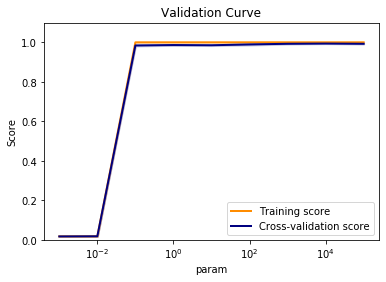

In [74]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [75]:
'''test data'''
est = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000, C=100000)
est.fit(np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1))

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
pred = est.predict(np.hstack(pred_train_all_list))

In [77]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.00        91

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 91  0  0  0  0]
 [ 0  0  0  0  0  0 90  0  0

In [78]:
pred_test = est.predict(np.hstack(pred_all_list))

In [79]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9711152249094009
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      0.96      0.98        93
           2       0.99      1.00      0.99        86
           3       0.95      0.98      0.96        90
           4       0.99      0.98      0.98        93
           5       0.96      0.96      0.96        91
           6       1.00      0.96      0.98        91
           7       0.97      0.97      0.97        88
           8       0.93      0.99      0.96        88
           9       0.94      0.93      0.94        89

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 89  1  0  0  1  0  0  1  1]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 88  0  0  0  1  1  0]
 [ 0  0  0  0 91  0  0  1  0  1]
 [ 0  0  0  1  1 87  0  0  0  2]
 [ 0  0  0  0

## validation_curve + LGBMClassifier
* np.hstack(pred_train_all_list)

In [80]:
'''LGBMClassifier'''
from lightgbm import LGBMClassifier

param_name = "reg_alpha"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [81]:
%%time

train_scores, test_scores = validation_curve(
    LGBMClassifier(
        min_child_samples=20,
        reg_alpha=0.1
    ),
    np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. reg_alpha=0.001, total=   3.8s
[CV] reg_alpha=0.01 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ................................... reg_alpha=0.01, total=   3.4s
[CV] reg_alpha=0.1 ...................................................
[CV] .................................... reg_alpha=0.1, total=   3.0s
[CV] reg_alpha=1.0 ...................................................
[CV] .................................... reg_alpha=1.0, total=   2.5s
[CV] reg_alpha=10.0 ..................................................
[CV] ................................... reg_alpha=10.0, total=   2.0s
[CV] reg_alpha=100.0 .................................................
[CV] .................................. reg_alpha=100.0, total=   1.6s
[CV] reg_alpha=1000.0 ................................................
[CV] ................................. reg_alpha=1000.0, total=   1.6s
[CV] reg_alpha=0.001 .................................................
[CV] .................................. reg_alpha=0.001, total=   3.8s
[CV] reg_alpha=0.01 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   54.0s finished


In [82]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 1.00000000e+00, 9.81796389e-01],
       [1.00000000e-02, 1.00000000e+00, 9.81796389e-01],
       [1.00000000e-01, 1.00000000e+00, 9.80684411e-01],
       [1.00000000e+00, 1.00000000e+00, 9.80684411e-01],
       [1.00000000e+01, 1.00000000e+00, 9.80668131e-01],
       [1.00000000e+02, 1.86625194e-02, 1.89655172e-02],
       [1.00000000e+03, 1.86625194e-02, 1.89655172e-02]])

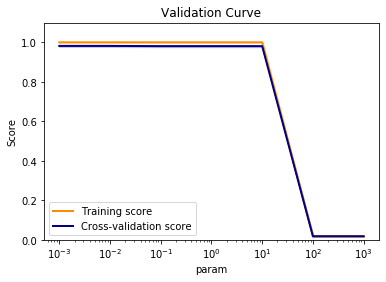

In [83]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [84]:
'''test data'''
est = LGBMClassifier(
        min_child_samples=50,
        reg_alpha=0.01
    )
est.fit(np.hstack(pred_train_all_list), np.argmax(ytrain, axis=1))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.01, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [85]:
pred = est.predict(np.hstack(pred_train_all_list))

In [86]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.00        91

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898

[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  0  0]
 [ 0  0 91  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0]
 [ 0  0  0  0 88  0  0  0  0  0]
 [ 0  0  0  0  0 91  0  0  0  0]
 [ 0  0  0  0  0  0 90  0  0

In [87]:
pred_test = est.predict(np.hstack(pred_all_list))

In [88]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9710346763279757
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        90
           1       1.00      0.96      0.98        93
           2       0.99      1.00      0.99        86
           3       0.94      0.99      0.96        90
           4       0.99      0.98      0.98        93
           5       0.96      0.97      0.96        91
           6       1.00      0.91      0.95        91
           7       0.97      0.99      0.98        88
           8       0.95      0.99      0.97        88
           9       0.95      0.93      0.94        89

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899

[[90  0  0  0  0  0  0  0  0  0]
 [ 0 89  1  1  0  1  0  0  0  1]
 [ 0  0 86  0  0  0  0  0  0  0]
 [ 0  0  0 89  0  0  0  1  0  0]
 [ 0  0  0  0 91  0  0  1  0  1]
 [ 0  0  0  0  1 88  0  0  1  1]
 [ 2  0  0  0